In [10]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# --------------------------
# 1) Helpers
# --------------------------

def token_to_float(tok: str) -> float:
    """Handles tokens like '20-000' or '-15-500' as decimals."""
    t = tok.strip()
    if '.' in t:
        return float(t)
    if '-' in t[1:]:
        return float(('-' + t[1:].replace('-', '.', 1)) if t.startswith('-') else t.replace('-', '.', 1))
    return float(t)

def parse_xy_from_filename(path):
    """Assumes ..._Xcoord_Ycoord.xy as last two underscore parts."""
    name = os.path.basename(path).rsplit('.',1)[0]
    parts = name.split('_')
    x = token_to_float(parts[-2])
    y = token_to_float(parts[-1])
    return x, y

# pseudo-Voigt (amplitude A at center x0, FWHM w, mixing eta, plus constant baseline c)
def pvoigt(x, A, x0, w, eta, c):
    sigma = w/(2*np.sqrt(2*np.log(2)))
    gamma = w/2
    G = np.exp(-(x - x0)**2/(2*sigma**2))
    L = gamma**2/((x - x0)**2 + gamma**2)
    return A*((1-eta)*G + eta*L) + c

def pvoigt_area(A, w, eta):
    """Area under pseudo-Voigt with amplitude A & FWHM w."""
    sigma = w/(2*np.sqrt(2*np.log(2)))
    gamma = w/2
    area_G = A * (1-eta) * np.sqrt(2*np.pi) * sigma
    area_L = A * eta * np.pi * gamma
    return area_G + area_L

def fit_one_peak(x, y, roi, w0=0.2):
    """
    Return dict with center, fwhm, area, amp.
    Uses light smoothing + baseline, then pVoigt fit in ROI.
    """
    m = (x >= roi[0]) & (x <= roi[1])
    if m.sum() < 7:
        return None
    xw, yw = x[m].astype(float), y[m].astype(float)

    # smooth (small window relative to step)
    dx = max(np.median(np.diff(xw)), 1e-6)
    Ws = max(5, int(round(0.02/dx)));  Ws += (1-Ws%2)
    ys = savgol_filter(yw, Ws, 2, mode="interp") if Ws < len(yw) else yw

    # baseline (broad SG window)
    Wb = max(11, int(round(1.0/dx)));  Wb += (1-Wb%2)
    yb = savgol_filter(ys, Wb, 2, mode="interp") if Wb < len(yw) else ys
    yc = ys - yb

    # seed from max in corrected window
    i0 = int(np.argmax(yc))
    x0 = xw[i0]
    A0 = max(yc[i0], 1.0)
    eta0 = 0.5
    c0 = np.median(yw) - np.median(yc)  # baseline level near ROI (not critical)

    p0 = [A0, x0, w0, eta0, c0]
    bounds = ([0, roi[0], 0, 0, -np.inf], [np.inf, roi[1], 2.0, 1.0, np.inf])

    try:
        popt, pcov = curve_fit(pvoigt, xw, yw, p0=p0, bounds=bounds, maxfev=50000)
        A, xc, w, eta, c = popt
        area = pvoigt_area(A, w, eta)
        return {"center": xc, "fwhm": w, "area": area, "amp": A, "eta": eta, "ok": True}
    except Exception:
        return None

def circular_mask(X, Y, center=(0.0,0.0), radius=None):
    """Return boolean mask inside circle. If radius None, infer from max extent."""
    cx, cy = center
    R = radius
    if R is None:
        R = np.nanmin([np.nanmax(np.abs(X-cx)), np.nanmax(np.abs(Y-cy))])
    return (X-cx)**2 + (Y-cy)**2 <= R**2

# --------------------------
# 2) Configuration
# --------------------------

# Folder with *.xy (set yours here)
folder = r"C:\\Dilan\\Study\\Master Thesis\\Characterization\\XRD\\30-09-2025 Dep No 1\\XY Data"

# Peak windows to map (example windows; adjust to your material!)
# e.g. perovskite example: {'100':(22.5, 23.5), '110':(31.0, 33.5), '002':(44.5, 46.5)}
PEAK_ROI = {
    '100': (29.5, 30.8),   # <-- put your actual windows
    '110': (39.0, 41.0),
    '002': (65.5, 67.5),
}

# Metric to visualize per map: 'area' (integrated intensity) or 'fwhm'
METRIC_FOR_PLOT = {'100': 'area', '110': 'area', '002': 'fwhm'}  # example: last panel shows FWHM

# Grid & sample geometry for the 3D surface
GRID_N = 100                         # grid density in x and y
SAMPLE_CENTER = (0.0, 0.0)           # change if needed
SAMPLE_RADIUS = None                 # None -> infer; else give mm radius, e.g. 17.5

# Colormap for surfaces
CMAP = "jet"                         # classic rainbow-like
VBOUNDS = None                       # e.g. {'100':(0,5), '110':(0,3), '002':(0.2,0.6)} to force global scales

# --------------------------
# 3) Load & measure
# --------------------------

files = sorted(glob.glob(os.path.join(folder, "*.xy")))
data_rows = []

if not files:
    # ---- synthetic example if folder is empty ----
    rng = np.random.default_rng(2)
    xs = np.linspace(-20, 20, 13)
    ys = np.linspace(-20, 20, 13)
    for X in xs:
        for Y in ys:
            # fake peak positions/intensities vary smoothly with radius
            r = np.hypot(X, Y)
            # synthetic scan x-axis:
            twotheta = np.linspace(20, 80, 2001)
            # make three peaks with random noise
            def make_peak(mu, amp, w):
                sigma = w/(2*np.sqrt(2*np.log(2)))
                return amp*np.exp(-(twotheta-mu)**2/(2*sigma**2))
            y = (make_peak(30.2,  120*(1-r/35), 0.35) +
                 make_peak(40.5,   80*(1-0.6*r/35), 0.28) +
                 make_peak(66.2,    1.0, 0.30)) + rng.normal(0, 0.5, twotheta.size)
            # save a "virtual" row per peak
            for name, roi in PEAK_ROI.items():
                fit = fit_one_peak(twotheta, y, roi)
                if fit:
                    data_rows.append([X, Y, name, fit["center"], fit["fwhm"], fit["area"], fit["amp"]])
else:
    # ---- real files ----
    for f in files:
        try:
            df = pd.read_csv(f, delim_whitespace=True, header=None, names=["X","Y"])
        except Exception:
            continue
        x, y = df["X"].to_numpy(float), df["Y"].to_numpy(float)
        # ensure ascending x
        if not np.all(np.diff(x) > 0):
            idx = np.argsort(x); x, y = x[idx], y[idx]
        # parse map coordinates
        Xc, Yc = parse_xy_from_filename(f)
        # measure each configured peak
        for name, roi in PEAK_ROI.items():
            fit = fit_one_peak(x, y, roi)
            if fit:
                data_rows.append([Xc, Yc, name, fit["center"], fit["fwhm"], fit["area"], fit["amp"]])

# Assemble tidy table
res = pd.DataFrame(data_rows, columns=["x","y","peak","center_deg","fwhm_deg","area","amplitude"])
print("Measured rows:", len(res))
print(res.head())


Measured rows: 183
      x    y peak  center_deg  fwhm_deg        area   amplitude
0   0.0  0.0  100   30.013392  0.220417    5.327284   22.705369
1   0.0  0.0  110   39.000000  0.327813   37.004853   71.864175
2   0.0  0.0  002   65.866250  0.229259  228.930586  938.092371
3  10.0  0.0  100   30.766300  0.137168    8.643458   40.115784
4  10.0  0.0  110   39.000000  1.595618  116.418146   46.448517


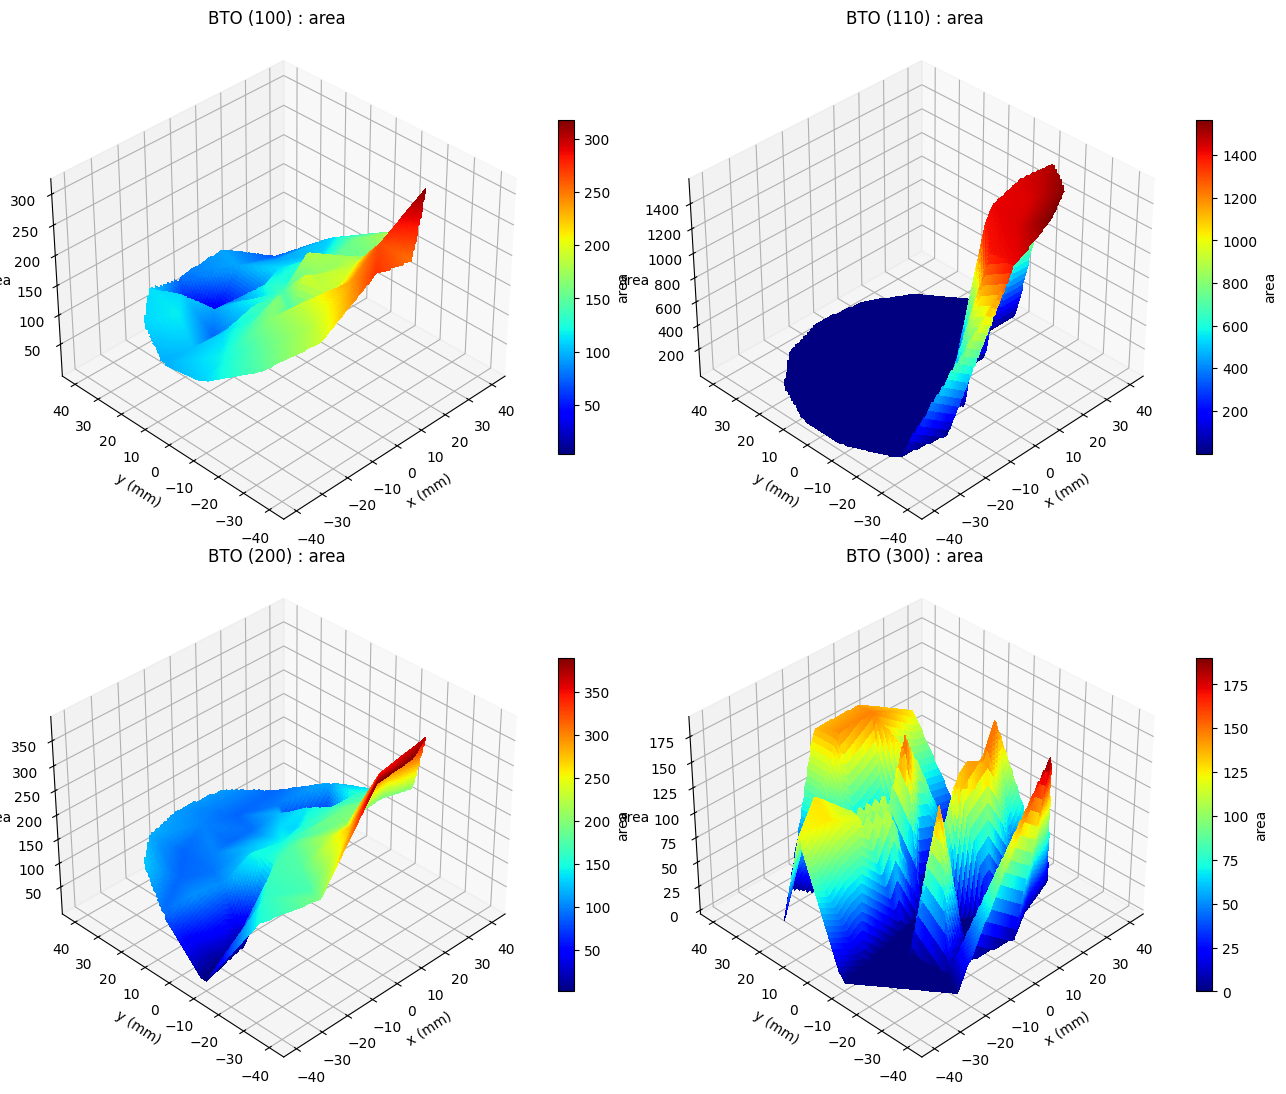

In [13]:
# --- BTO spatial XRD map: (100), (110), (200), (300) in one figure ---

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# ========= helpers =========

def token_to_float(tok: str) -> float:
    """Convert tokens like '20-000' or '-15-500' to float."""
    t = tok.strip()
    if '.' in t:
        return float(t)
    # allow dash as decimal separator after (optional) sign
    if '-' in t[1:]:
        return float(('-' + t[1:].replace('-', '.', 1)) if t.startswith('-') else t.replace('-', '.', 1))
    return float(t)

def parse_xy_from_filename(path):
    """Assumes ..._<Xcoord>_<Ycoord>.xy as the last two underscore-separated tokens."""
    name = os.path.basename(path).rsplit('.', 1)[0]
    parts = name.split('_')
    return token_to_float(parts[-2]), token_to_float(parts[-1])

def pvoigt(x, A, x0, w, eta, c):
    """Pseudo-Voigt (A ~ height, w = FWHM, 0<=eta<=1), + constant baseline c."""
    sigma = w/(2*np.sqrt(2*np.log(2)))
    gamma = w/2
    G = np.exp(-(x - x0)**2/(2*sigma**2))
    L = gamma**2/((x - x0)**2 + gamma**2)
    return A*((1-eta)*G + eta*L) + c

def pvoigt_area(A, w, eta):
    """Area under pseudo-Voigt peak."""
    sigma = w/(2*np.sqrt(2*np.log(2)))
    gamma = w/2
    return A*( (1-eta)*np.sqrt(2*np.pi)*sigma + eta*np.pi*gamma )

def fit_one_peak(x, y, roi, w0=0.20):
    """
    Fit a single peak in ROI with pseudo-Voigt after light smoothing & baseline removal.
    Returns dict with center, fwhm, area, amplitude, eta.
    """
    m = (x >= roi[0]) & (x <= roi[1])
    if m.sum() < 7:
        return None

    xw, yw = x[m].astype(float), y[m].astype(float)
    dx = max(np.median(np.diff(xw)), 1e-6)

    # light denoising that preserves linewidths
    Ws = max(5, int(round(0.02/dx)));  Ws += (1-Ws % 2)
    ys = savgol_filter(yw, Ws, 2, mode="interp") if Ws < len(yw) else yw

    # broad baseline
    Wb = max(11, int(round(1.0/dx)));  Wb += (1-Wb % 2)
    yb = savgol_filter(ys, Wb, 2, mode="interp") if Wb < len(yw) else ys
    yc = ys - yb

    i0 = int(np.argmax(yc))
    x0 = xw[i0]
    A0 = max(yc[i0], 1.0)
    p0 = [A0, x0, w0, 0.5, np.median(yw)]
    bounds = ([0, roi[0], 0, 0, -np.inf], [np.inf, roi[1], 2.0, 1.0, np.inf])

    try:
        popt, _ = curve_fit(pvoigt, xw, yw, p0=p0, bounds=bounds, maxfev=50000)
        A, xc, w, eta, c = popt
        return {"center": xc, "fwhm_deg": float(w), "area": float(pvoigt_area(A, w, eta)),
                "amplitude": float(A), "eta": float(eta)}
    except Exception:
        return None

def circular_mask(X, Y, center=(0.0, 0.0), radius=None):
    """Mask inside a circle; if radius None, infer from grid extents."""
    cx, cy = center
    if radius is None:
        radius = np.nanmin([np.nanmax(np.abs(X - cx)), np.nanmax(np.abs(Y - cy))])
    return (X - cx)**2 + (Y - cy)**2 <= radius**2

# ========= configuration (EDIT THESE) =========

folder = r"C:\\Dilan\\Study\\Master Thesis\\Characterization\\XRD\\30-09-2025 Dep No 1\\XY Data"  # <-- set your folder

# BTO (Cu Kα, a≈4.00 Å) approximate 2θ windows; tweak for your data if needed
PEAK_ROI_BTO = {
    "(100)": (21.6, 22.9),   # around 22.2°
    "(110)": (30.8, 32.4),   # around 31.6°
    "(200)": (44.6, 46.2),   # around 45.3°
    "(300)": (69.7, 71.5),   # around 70.6°
}

# What to plot on the Z axis (per panel)
METRIC = "area"          # choose "area" (integrated intensity) or "fwhm_deg"

# Figure style
CMAP = "jet"             # rainbow-like (use "turbo"/"plasma" for perceptual maps)
GRID_N = 120             # interpolation grid density
SAMPLE_CENTER = (0.0, 0.0)
SAMPLE_RADIUS = None     # None → infer; or give e.g. 25.0 (mm)

# Optionally, lock color limits to compare samples (per metric)
# e.g., for area: VBND = (0, 6); for FWHM: VBND = (0.2, 0.5)
GLOBAL_VMIN_VMAX = None

# ========= 1) measure all files =========

files = sorted(glob.glob(os.path.join(folder, "*.xy")))
rows = []

if not files:
    raise RuntimeError("No .xy files found in the folder you set.")

for f in files:
    try:
        df = pd.read_csv(f, delim_whitespace=True, header=None, names=["X", "Y"])
    except Exception:
        continue

    x = df["X"].to_numpy(float)
    y = df["Y"].to_numpy(float)

    # ensure ascending x
    if not np.all(np.diff(x) > 0):
        idx = np.argsort(x); x, y = x[idx], y[idx]

    Xc, Yc = parse_xy_from_filename(f)

    for hk, roi in PEAK_ROI_BTO.items():
        fit = fit_one_peak(x, y, roi)
        if fit:
            rows.append({
                "file": os.path.basename(f),
                "x": Xc, "y": Yc,
                "hkl": hk,
                "center_deg": fit["center"],
                "fwhm_deg": fit["fwhm_deg"],
                "area": fit["area"],
                "amplitude": fit["amplitude"],
                "eta": fit["eta"]
            })

res = pd.DataFrame(rows)
if res.empty:
    raise RuntimeError("No peaks were fitted. Check PEAK_ROI_BTO windows and data quality.")

# ========= 2) build regular grid & mask =========

xi = np.linspace(res["x"].min(), res["x"].max(), GRID_N)
yi = np.linspace(res["y"].min(), res["y"].max(), GRID_N)
XI, YI = np.meshgrid(xi, yi)
MASK = circular_mask(XI, YI, center=SAMPLE_CENTER, radius=SAMPLE_RADIUS)

# ========= 3) one figure with four panels (100,110,200,300) =========

fig = plt.figure(figsize=(13, 11))

order = ["(100)", "(110)", "(200)", "(300)"]
for k, hk in enumerate(order, start=1):
    sel = res[res["hkl"] == hk].copy()
    if sel.empty:
        continue

    # pick metric column
    if METRIC not in sel.columns:
        raise KeyError(f"Requested metric '{METRIC}' not in data columns {list(sel.columns)}")
    Zs = pd.to_numeric(sel[METRIC], errors="coerce").to_numpy(float)
    pts = sel[["x", "y"]].to_numpy(float)

    # scattered → gridded (linear interpolation)
    ZI = griddata(pts, Zs, (XI, YI), method="linear")
    ZI = np.ma.array(ZI, mask=~MASK)

    ax = fig.add_subplot(2, 2, k, projection='3d')

    vmin = vmax = None
    if GLOBAL_VMIN_VMAX is not None:
        vmin, vmax = GLOBAL_VMIN_VMAX

    surf = ax.plot_surface(
        XI, YI, ZI,
        rstride=1, cstride=1,
        cmap=CMAP, norm=Normalize(vmin=vmin, vmax=vmax),
        linewidth=0, antialiased=False
    )

    ax.set_title(f"BTO {hk} : {METRIC}", pad=10)
    ax.set_xlabel("x (mm)"); ax.set_ylabel("y (mm)")
    ax.set_zlabel(METRIC)
    ax.view_init(elev=35, azim=-135)
    cbar = fig.colorbar(surf, ax=ax, shrink=0.65, pad=0.05)
    cbar.set_label(METRIC)

plt.tight_layout()
plt.show()


KeyError: 'hkl'

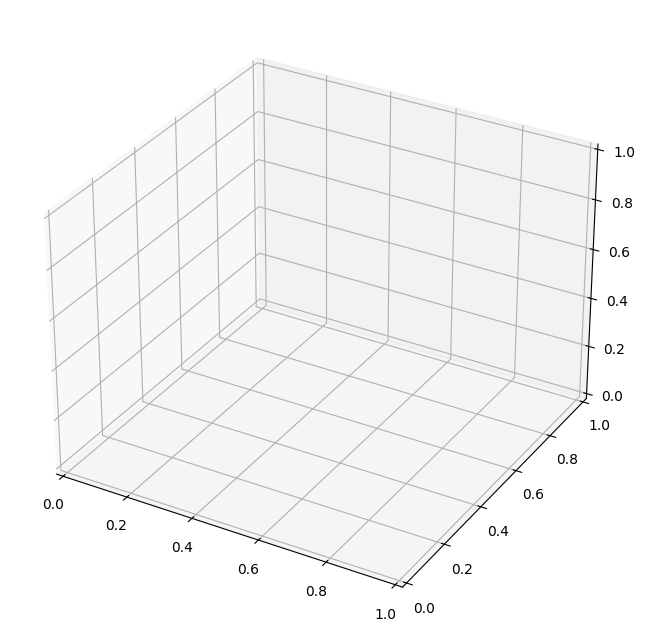

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa

PEAKS = ["(100)", "(110)", "(200)", "(300)"]
METRIC = "area"                    # or "fwhm_deg"
ALPHAS = [0.65, 0.55, 0.50, 0.45]  # different transparencies
CMAPS  = ["Reds", "Blues", "Greens", "Purples"]  # per-plane colormaps
GRID_N = 140

xi = np.linspace(res["x"].min(), res["x"].max(), GRID_N)
yi = np.linspace(res["y"].min(), res["y"].max(), GRID_N)
XI, YI = np.meshgrid(xi, yi)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Optional: force same z-scale across planes for comparability
GLOBAL_VMIN = None  # e.g., 0.2
GLOBAL_VMAX = None  # e.g., 0.5

for hk, alpha, cmap in zip(PEAKS, ALPHAS, CMAPS):
    sel = res[res["hkl"] == hk].copy()
    if sel.empty or METRIC not in sel.columns:
        continue

    pts = sel[["x","y"]].to_numpy(float)
    zs  = np.asarray(sel[METRIC], dtype=float)

    ZI = griddata(pts, zs, (XI, YI), method="linear")
    # mask NaNs to avoid dropouts
    ZI = np.ma.masked_invalid(ZI)

    vmin = GLOBAL_VMIN if GLOBAL_VMIN is not None else np.nanpercentile(zs, 5)
    vmax = GLOBAL_VMAX if GLOBAL_VMAX is not None else np.nanpercentile(zs, 95)

    surf = ax.plot_surface(
        XI, YI, ZI,
        rstride=1, cstride=1, cmap=cmap,
        norm=Normalize(vmin=vmin, vmax=vmax),
        linewidth=0, antialiased=False, alpha=alpha
    )

ax.set_title(f"BTO spatial map — overlaid 3D surfaces of {METRIC}")
ax.set_xlabel("x (mm)"); ax.set_ylabel("y (mm)"); ax.set_zlabel(METRIC)
ax.view_init(elev=35, azim=-135)
plt.tight_layout()
plt.show()
